In [4]:
import numpy as np
import pandas as pd
from scipy.special import gammaln, gamma
from collections import Counter
from scipy.optimize import basinhopping
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the data and process it.

df = pd.read_csv("../mturk_surveys.csv")
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))

# Calculate the time period of each survey answer. 
# Below we take out time period to be 30-day periods. 
# We can change this to be weeks, months, or anything else
window_length = 30
minDate = min(df['date'])
df['period'] = (df['date'] - minDate).dt.days // window_length 

#df = df[df['period'] < 21]
# Create a list of all unique worker IDs 
workers = pd.DataFrame(list(set(df.worker_id)), columns=['worker_id']).reset_index().set_index('worker_id')

# Fix the issue of duplicate records within the same period.
data = df[['worker_id', 'period']].drop_duplicates().pivot_table(
    index = 'worker_id',
    values = 'period',                    
    aggfunc=('count','min','max')
).join(workers).set_index('index').sort_index()

# Aggregate the capture histories
#data = data.groupby(['min', 'max', 'count']).size().reset_index(name='count_history')
S = df['period'].max() + 1
dat = np.zeros(S + 1)
out = Counter(data['count'].values)
for k,v in out.items():
    dat[k] = v
V = len(workers)
print(S, V)

36 46145


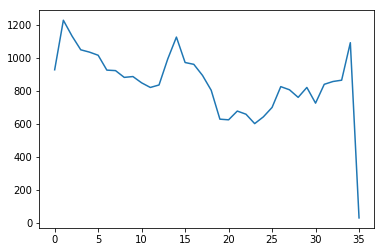

In [5]:
ddd = dict(Counter(data[data['count'] == 1]['max'].values))
lists = sorted(ddd.items())
x, y = zip(*lists)
plt.plot(x, y)

In [9]:
zd = df[['worker_id', 'period']].drop_duplicates()

In [22]:
for i in range(0, 36):
    print(i, Counter(Counter(zd[zd['period']<=i]['worker_id'].values).values()))

0 Counter({1: 2768})
1 Counter({1: 4599, 2: 522})
2 Counter({1: 6032, 2: 904, 3: 211})
3 Counter({1: 7231, 2: 1165, 3: 363, 4: 126})
4 Counter({1: 8363, 2: 1469, 3: 482, 4: 218, 5: 79})
5 Counter({1: 9458, 2: 1718, 3: 630, 4: 265, 5: 155, 6: 46})
6 Counter({1: 10347, 2: 1986, 3: 726, 4: 338, 5: 191, 6: 123, 7: 32})
7 Counter({1: 11234, 2: 2237, 3: 814, 4: 405, 5: 230, 6: 147, 7: 88, 8: 24})
8 Counter({1: 12022, 2: 2525, 3: 919, 4: 438, 5: 263, 6: 185, 7: 110, 8: 68, 9: 20})
9 Counter({1: 12874, 2: 2693, 3: 1035, 4: 501, 5: 295, 6: 210, 7: 127, 8: 94, 9: 54, 10: 15})
10 Counter({1: 13727, 2: 2852, 3: 1110, 4: 565, 5: 333, 6: 236, 7: 143, 8: 119, 9: 66, 10: 51, 11: 9})
11 Counter({1: 14417, 2: 3051, 3: 1188, 4: 592, 5: 404, 6: 253, 7: 153, 8: 141, 9: 87, 10: 63, 11: 39, 12: 9})
12 Counter({1: 15170, 2: 3219, 3: 1265, 4: 631, 5: 447, 6: 276, 7: 181, 8: 138, 9: 111, 10: 80, 11: 46, 12: 35, 13: 8})
13 Counter({1: 16157, 2: 3391, 3: 1297, 4: 670, 5: 449, 6: 331, 7: 195, 8: 141, 9: 122, 10: 9

In [20]:
Counter(Counter(zd[zd['period']<=0]['worker_id'].values).values())

Counter({1: 2768})

In [51]:
dat =  np.array([0, 25, 12, 5, 5,  1 , 2])
S, V = 6, sum(dat)
print(S, V)

6 50


In [52]:
# Alpha Beta version
def BB(S, k, alpha, beta):
    up = gamma(k + alpha) * gamma(S - k + beta) * gamma(alpha + beta)
    down = gamma(alpha) * gamma(beta) * gamma(S + alpha + beta)
    return up / down

In [53]:
def mll(initParams):
    # params
    f0    = initParams[0]
    alpha = initParams[1]
    beta  = initParams[2]
    
    N = gammaln(V + f0 +1) - gammaln(f0 + 1)
    L0 = f0 * np.log(BB(S, 0, alpha, beta))
    Lk = 0
    
    # fk likelihood
    for k in range(1, len(dat)):
        Lk += dat[k] * np.log(BB(S, k, alpha, beta))
    
    obj = N + L0 + Lk
    
    #if -obj < -118000:
    #    print(f0, alpha, beta, -obj)
    
    return -obj

In [58]:
# Bounds
B= ((0,10000), (0, 10), (0, 10))

#args
minimizer_kwargs = dict(method="TNC", bounds=B)

#run
initParams = np.array([9000, .005, 5])
res = basinhopping(mll, initParams, minimizer_kwargs=minimizer_kwargs)
print(res)
print(res['x'][0] + V)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


                        fun: 32.114447550051636
 lowest_optimization_result:      fun: 32.114447550051636
     jac: array([-0.00045475,  7.1361228 ,  2.74918648])
 message: 'Linear search failed'
    nfev: 95
     nit: 8
  status: 4
 success: False
       x: array([9306.2900511 ,    0.00375571,    2.36366445])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 101
                       nfev: 8026
                        nit: 100
                          x: array([9306.2900511 ,    0.00375571,    2.36366445])
9356.290051098558


In [ ]:
mll([403608.7895533 ,      0.02039742,      3.7429387 ,      0.01037844,
            0.20782324])

In [ ]:
mll([83793.7773379 ,     0.19999895,     4.07278073,     0.01197954,
           0.70142692])

In [ ]:
mll([234776.72579006,      0.03929604,      3.78447354,      0.01050833,
            0.33356468])

In [ ]:
mll([57392.28189185,     0.38756928,     4.32406151,     0.01459061,
           0.80091354])

In [ ]:
mll([125104.16766101,      0.09702091,      3.89744013,      0.01093061,
            0.54677371])

In [ ]:
mll([12.8,      0.09702091,      3.89744013])

In [ ]:
ddd = dict(Counter(data[data['count'] == 1]['max'].values))
lists = sorted(ddd.items())
x, y = zip(*lists)
plt.plot(x, y)

In [ ]:
lists

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt